# Benchmarking Suites
This notebook visualizes characteristics of the different benchmarking suites (sets of datasets) proposed in the paper. The results are used to create Figure 1 in Section 5.

In [1]:
from pathlib import Path
import re

import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import numpy as np
import pandas as pd
import seaborn

In [2]:
PROJECT_ROOT = Path(".").absolute().parent
DATA_DIRECTORY = PROJECT_ROOT / "data"
FIGURE_DIRECTORY = PROJECT_ROOT / "figures" / "datasets"
FIGURE_DIRECTORY.mkdir(parents=True, exist_ok=True)

In [3]:
metadata = pd.read_csv(DATA_DIRECTORY / "metadata.csv")
metadata.head(3)

,did,name,version,uploader,status,format,MajorityClassSize,MaxNominalAttDistinctValues,MinorityClassSize,NumberOfClasses,NumberOfFeatures,NumberOfInstances,NumberOfInstancesWithMissingValues,NumberOfMissingValues,NumberOfNumericFeatures,NumberOfSymbolicFeatures
0,3,kr-vs-kp,1,1,active,ARFF,1669.0,3.0,1527.0,2.0,37.0,3196.0,0.0,0.0,0.0,37.0
1,12,mfeat-factors,1,1,active,ARFF,200.0,10.0,200.0,10.0,217.0,2000.0,0.0,0.0,216.0,1.0
2,23,cmc,1,1,active,ARFF,629.0,4.0,333.0,3.0,10.0,1473.0,0.0,0.0,2.0,8.0


## Datasets by size and dimensionality

In [4]:
features = ["NumberOfClasses", "NumberOfFeatures", "NumberOfInstances", "NumberOfInstancesWithMissingValues", "NumberOfMissingValues", "NumberOfSymbolicFeatures"]
def name_with_space(name: str) -> str:
    words = re.findall(r"([A-Z][a-z]+)", name)
    return ' '.join(word if word not in ['Of', 'With'] else word.lower() for word in words)
    
    
datasets = metadata[features].rename(
    columns={feature: name_with_space(feature) for feature in features}
)

def determine_task_type(number_of_classes: int) -> str:
    if number_of_classes == 2:
        return "Binary Classification"
    if number_of_classes > 2:
        return "Multiclass Classification"
    return "Regression"
    
datasets["type"] = datasets["Number of Classes"].apply(determine_task_type)
datasets["Percentage of Categorical Features"] = (datasets["Number of Symbolic Features"] / datasets["Number of Features"]) * 100
datasets["Percentage of Missing Values"] = (datasets["Number of Missing Values"] / (datasets["Number of Instances"] * datasets["Number of Features"])) * 100

In [5]:
color_map = {"Regression": "#2ba02b", "Multiclass Classification": "#fa7f12", "Binary Classification": "#1f77b4"}

In [6]:
def with_large_text(ax, xlabel: str, ylabel: str, title: str): 
    ax.set_title(title, size='xx-large') 
    ax.set_ylabel(ylabel, size='xx-large')
    ax.set_xlabel(xlabel, size='xx-large')
    ax.tick_params(axis='both', which = 'both', labelsize = 18)
    
def histplot(data: pd.DataFrame, column: str, log_scale: int = 10):
    multiple_types = data["type"].nunique() > 1
    ax = seaborn.histplot(
        data,
        x=column,
        hue="type",
        multiple="stack",
        log_scale=log_scale,
        hue_order=["Regression", "Multiclass Classification", "Binary Classification"],
        palette=color_map,
        shrink=0.8,  # allow some horizontal space between bars
        linewidth=0,  # don't draw lines on edges
        bins=10,
    )
    with_large_text(ax, xlabel=column, ylabel="Datasets", title=f"Datasets by {column}")
    
    if legend := ax.get_legend():
        if multiple_types:
            legend.set_title("")
        else:
            legend.remove()
            
    return ax
    

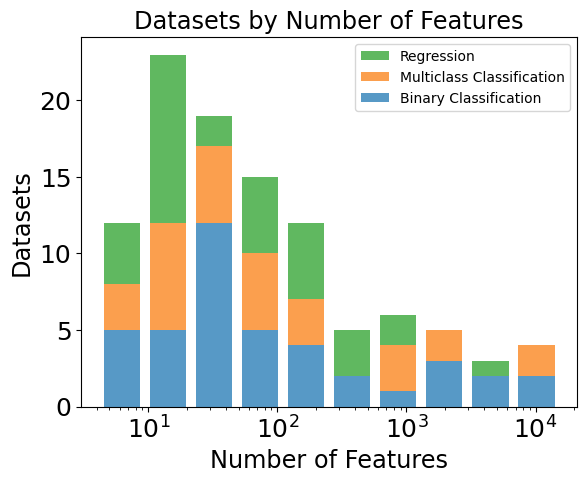

In [7]:
fig  = plt.figure()
ax = histplot(datasets, column="Number of Features")

with PdfPages(FIGURE_DIRECTORY / f"hist-features.pdf") as f:
    f.savefig(fig, bbox_inches="tight")

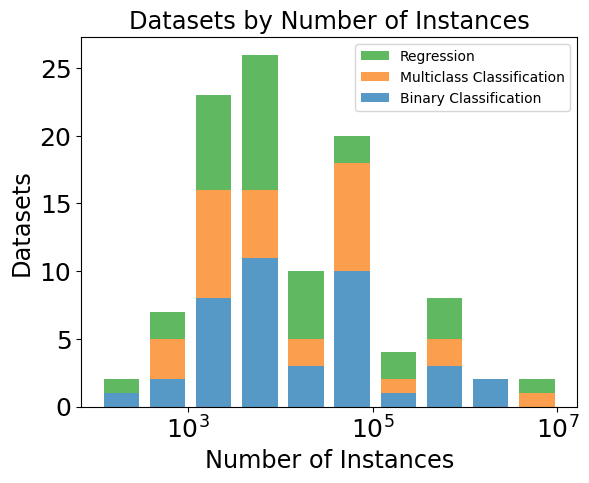

In [8]:
fig  = plt.figure()
ax = histplot(datasets, column="Number of Instances")

with PdfPages(FIGURE_DIRECTORY / f"hist-instances.pdf") as f:
    f.savefig(fig, bbox_inches="tight")

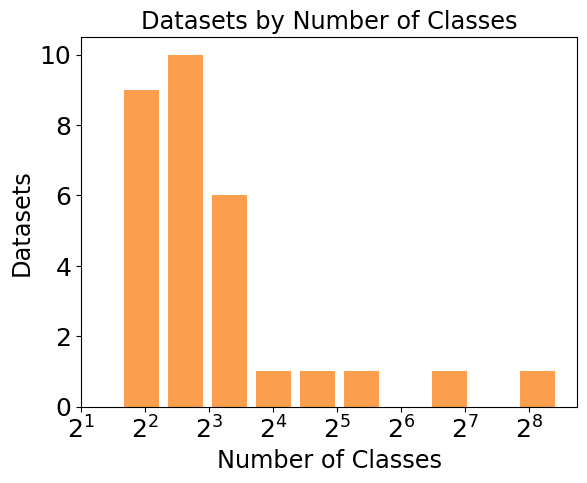

In [9]:
fig  = plt.figure()
ax = histplot(datasets[datasets["type"] == "Multiclass Classification"], column="Number of Classes", log_scale=2)

tick_locations = [2**i for i in range(1, 9)]
ax.set_xticks(tick_locations)
ax.set_xticklabels([f"$2^{i}$" for i in range(1, 9)])

with PdfPages(FIGURE_DIRECTORY / f"hist-classes.pdf") as f:
    f.savefig(fig, bbox_inches="tight")

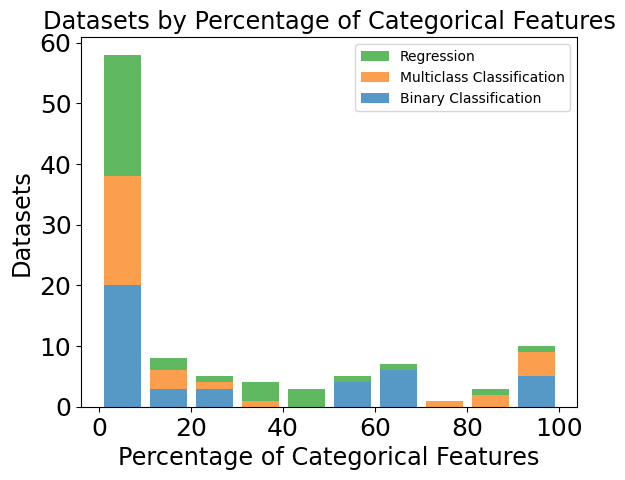

In [10]:
fig  = plt.figure()
ax = histplot(datasets, column="Percentage of Categorical Features", log_scale=False)

with PdfPages(FIGURE_DIRECTORY / f"hist-categoricals.pdf") as f:
    f.savefig(fig, bbox_inches="tight")

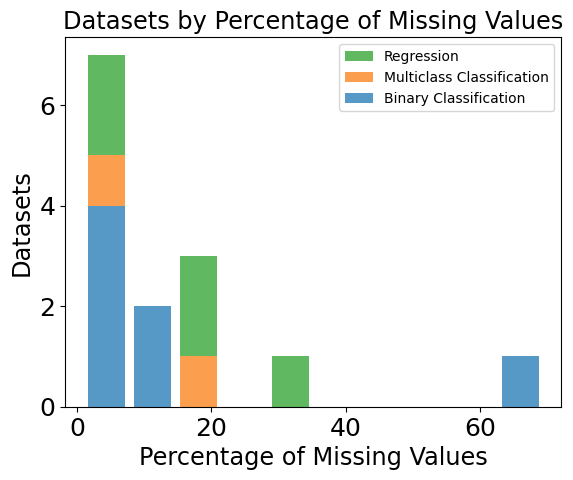

In [11]:
fig  = plt.figure()
ax = histplot(datasets[datasets["Percentage of Missing Values"] > 0], column="Percentage of Missing Values", log_scale=False)

with PdfPages(FIGURE_DIRECTORY / f"hist-values.pdf") as f:
    f.savefig(fig, bbox_inches="tight")

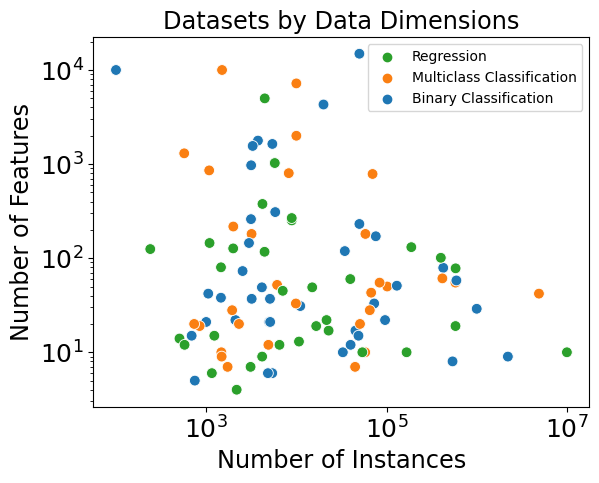

In [21]:
fig  = plt.figure()
ax = seaborn.scatterplot(
    datasets,
    x="Number of Instances",
    y="Number of Features",
    hue="type",
    hue_order=["Regression", "Multiclass Classification", "Binary Classification"],
    palette=color_map,
    s=60,
)
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_title("Datasets by Data Dimensions", size='xx-large')
ax.legend().set_title("")
with_large_text(
    ax, 
    xlabel="Number of Instances", 
    ylabel="Number of Features", 
    title="Datasets by Data Dimensions",
)

with PdfPages(FIGURE_DIRECTORY / f"scatter-sizes.pdf") as f:
    f.savefig(fig, bbox_inches="tight")